# Выявление параметров успешности игр в интернет-магазине "Стримчик"

## Вводная информация

Заказчик: интернет-магазин компьютерных игр. 

Требуется разработать принцип работы с данными, чтобы можно было прогнозировать продажи на следующий год. Нужно выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


**Данные**

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков»

Данные за 2016 год могут быть неполными.

## Загрузка данных

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import norm
from math import sqrt

In [2]:
#загрузка данных
data = pd.read_csv('/datasets/games.csv')

## Предобработка данных

### Обзор данных

In [20]:
#несколько строк
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [21]:
#информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [22]:
#приведем наименования колонок к стандарту PEP8
data.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 
                'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
print('Имена полей в датасете: ', data.columns)

Имена полей в датасете:  Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### Обработка дубликаторв

In [23]:
#посчитаем количество дубликатов
print('Количество дублирующихся строк в датасете: ', data.duplicated().sum())

Количество дублирующихся строк в датасете:  0


### Обработка пропущенных значений

In [24]:
#заполнение строк в которых есть пустое значение в заданном поле
def filling_nans(df, field, meaning):
    nan_before = df[field].isna().sum()
    df[field] = df[field].fillna(meaning)
    nan_after = df[field].isna().sum()
    return nan_before, nan_after # возвращает число строк в которых есть пустые значения до и после их заполнения

In [25]:
#обработка пропущенных значений в поле name
before, after = filling_nans(data, 'name', 'unknown')
print('Количество пропущенных значений в поле name: ', before)
print('Количество пропущенных значений в поле name после заполнения пропусков: ', after)

Количество пропущенных значений в поле name:  2
Количество пропущенных значений в поле name после заполнения пропусков:  0


In [26]:
#обработка пропущенных значений в поле genre. Удаление
print('Количество пропущенных значений в поле name: ', data['genre'].isna().sum())
data = data.dropna(subset=['genre'])
print('Количество пропущенных значений в поле name после удаления пропусков: ', data['genre'].isna().sum())
data = data.reset_index()

Количество пропущенных значений в поле name:  2
Количество пропущенных значений в поле name после удаления пропусков:  0


In [27]:
#обработка пропущенных значений в поле rating
before, after = filling_nans(data, 'rating', 'unknown')
print('Количество пропущенных значений в поле rating: ', before)
print('Количество пропущенных значений в поле genre после заполнения пропусков: ', after)

Количество пропущенных значений в поле rating:  6764
Количество пропущенных значений в поле genre после заполнения пропусков:  0


In [28]:
#проверим есть ли значения critic_score = 0
data.query('critic_score == 0').value_counts()

Series([], dtype: int64)

In [29]:
#проверим есть ли значения user_score = 0
data.query('user_score == 0').value_counts()

Series([], dtype: int64)

В датасете не обнаружены нулевые значения для полей:
- critic_score
- user_score

Судя по всему эти значения являются пустыми, т.к. для соответсвующих игр еще не было оценок. Заполним пустые значения для этих трех полей нулем.

In [30]:
#обработка пропущенных значений в поле critic_score
before, after = filling_nans(data, 'critic_score', 0)
print('Количество пропущенных значений в поле critic_score: ', before)
print('Количество пропущенных значений в поле critic_score после заполнения пропусков: ', after)

Количество пропущенных значений в поле critic_score:  8576
Количество пропущенных значений в поле critic_score после заполнения пропусков:  0


In [31]:
#обработка пропущенных значений в поле user_score
before, after = filling_nans(data, 'user_score', 0)
print('Количество пропущенных значений в поле user_score: ', before)
print('Количество пропущенных значений в поле user_score после заполнения пропусков: ', after)

Количество пропущенных значений в поле user_score:  6699
Количество пропущенных значений в поле user_score после заполнения пропусков:  0


In [32]:
#заполнение пустых значений в поле year_of_release медианными значениями, сгруппированными по платформе релиза игры
for t in data['platform'].unique():
    data.loc[(data['platform'] == t) & (data['year_of_release'].isna()), 'year_of_release'] = \
    data.loc[(data['platform'] == t), 'year_of_release'].median()

In [33]:
#проверим наличие пустых значений в датасете
data.isna().sum()

index              0
name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

### Изменение типов данных

In [34]:
#функция для изменения типа столбца датафрейма
def change_type(df, field, new_type):
    df[field] = df[field].astype(new_type)
    return df

In [35]:
#изменение типов данных critic_score и year_of_release
change_type(data, 'critic_score', int)
change_type(data, 'year_of_release', int);

In [36]:
#посмотрим уникальные данные в поле user_score
data['user_score'].unique()

array(['8', 0, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [37]:
#замена значения tbd на 0
for i in range(0, data.shape[0]):
    if data.loc[i, 'user_score'] == 'tbd':
        data.loc[i, 'user_score'] = 10

In [38]:
#изменение типов данных user_score на float
change_type(data, 'user_score', float);

### Вывод к разделу 3

Датасет состоит из 16 715 строк. Содержит 11 колонок.
Не содержит дубликатов.
Заполнены пропущенные значения в полях `name` и `rating` значением `unknown`.
Удалены две строки, которые содержали пустые значения в поле `genre`.

Пропущенные значения в полях:
- `critic_score`
- `user_score`
Заполнены значением `0`. Т.к. судя по всему это те игры для которых еще не проставлены какие-либо оценки пользователями и критиками.

Пропущенные значения в поле `year_of_release` заполнены медианными значениями, рассчитанными из данных сгруппированных по платформе релиза игры.

Для следующих полей был изменен тип переменной на `int`:
- `year_of_release`
- `critic_score`

Для поля `user_score` в ряде строк было значение типа `str` `tbd`. Для того, чтобы можно было далее проводить манипуляции с числовыми значениями, значение `tbd` заменено на 20 (чтобы можно было отделить эти значения при необходимости) и тип поля заменен на `float`.

## Исследовательский анализ данных

### Анализ количества игр выпускаемых в разные годы

In [39]:
#сгруппируем игры по годам выпуска
data_years_pivot = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc='count')
data_years_pivot

,name
year_of_release,
1980,9
1981,46
1982,53
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


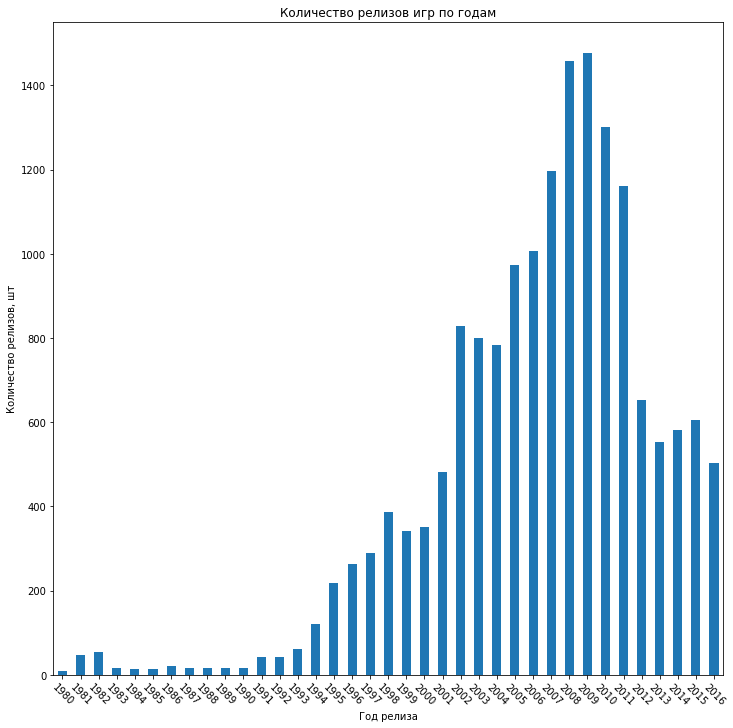

In [40]:
#данные по релизу игр по годам
data_years_pivot['name'].plot(kind='bar', figsize=(12, 12), title='Количество релизов игр по годам', 
                              xlabel='Год релиза', ylabel='Количество релизов, шт');
plt.xticks(rotation=-45);

**Вывод**

Релизы игр были на стабильно низком уровне до 1994 года (ниже 100 релизов в год). После этого пошел стабильный рост до 2009 года (до уровня 1476 релизов). После этого пошла небольшая ежегодная убыль, а в 2012 году произошел резкий спад до, примерно, 600 релизов в год и такой уровень сохраняется до сих пор.

### Анализ продаж по платформам

In [41]:
#добавление поля с суммой всех продаж по всем континентам
pd.options.mode.chained_assignment = None
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,unknown,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,unknown,31.38


In [42]:
#сводная таблица по релизам по годам и платформам
platform_sales_pivot = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
platform_sales_pivot.sort_values('total_sales', ascending=False)

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


Для дальнейшего анализа возьму первые 6 платформ, т.к. они сильно опережают остальные по продажам:
- PS2
- X360
- PS3
- Wii
- DS
- PS

In [43]:
#обор данных по интересующим платформам в отдельный датасет
data_top_platform = data.query('platform in ["PS2", "X360", "PS3", "Wii", "DS", "PS"]')

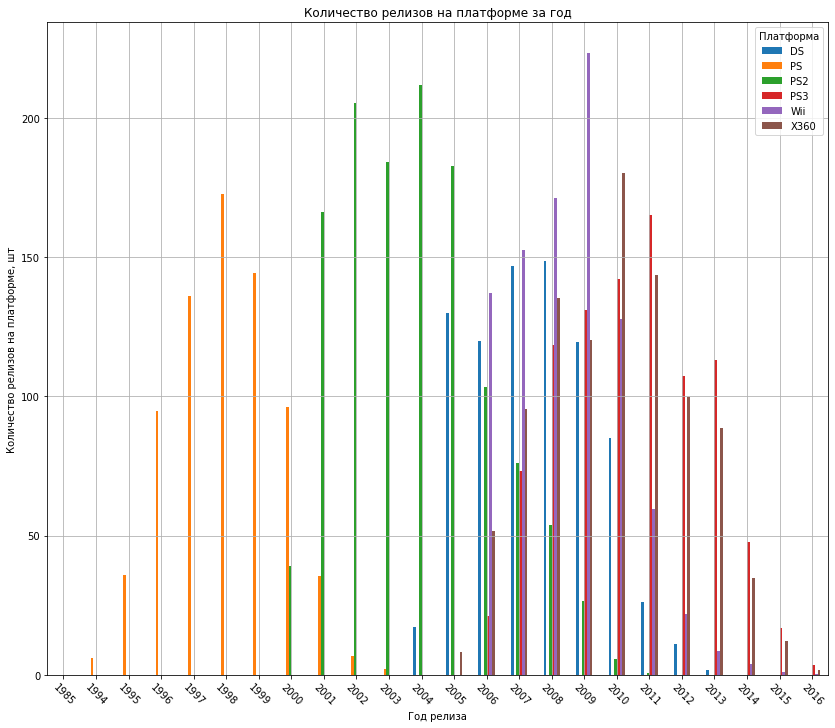

In [50]:
#сводная таблица по топовым платформам по годам
top_platform_sales_pivot = data_top_platform.pivot_table(index='year_of_release', values='total_sales', 
                                                         columns='platform', aggfunc='sum')
top_platform_sales_pivot.plot(kind='bar', figsize=(14, 12), title='Количество релизов на платформе за год', 
                              xlabel='Год релиза', ylabel='Количество релизов на платформе, шт');
plt.xticks(rotation=-45);
plt.legend(title='Платформа');


**Вывод**

Платформы с наибольшими продажами:
- PS2
- X360
- PS3
- Wii
- DS
- PS

Анализ показал, что новые платформы появляется и исчезают в среднем за 11 лет.

### Отбор данных за актуальный период

In [45]:
#отбор актуальных данных для дальнейшей работы
data_actual = data.query('year_of_release > 2011')
data_actual.shape[0]

2895

**Вывод**

Согласно полученным данным в разделе 4.1 последнее изменение поведения продаж произошло после 2011 года. Упало где-то до 600 штук и остается стабильным до текущего момента. Актуальный период: 2011 - наст.вр. В новом датасете 2895 строк.

### Платформы, лидирующие по продажам

In [46]:
#сводная таблица по релизам по годам и платформам
platform_sales_actual_pivot = data_actual.pivot_table(index='platform', values='total_sales', aggfunc='sum')
platform_sales_actual_pivot.sort_values('total_sales', ascending=False)

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,195.80
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.44
Wii,35.37


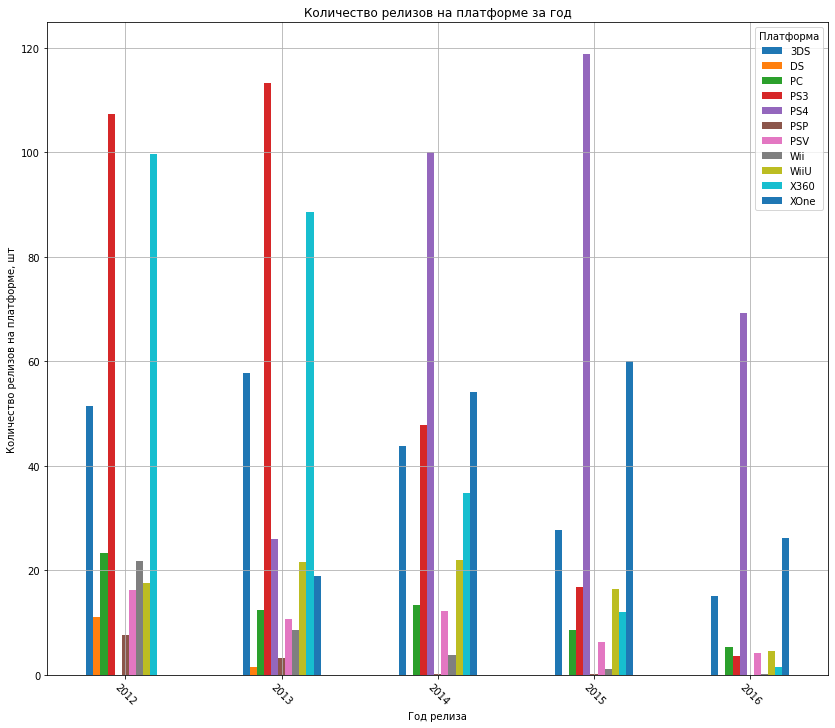

In [49]:
#сводная таблица по актуальным платформам по годам
platform_actual_pivot = data_actual.pivot_table(index='year_of_release', values='total_sales', 
                                                columns='platform', aggfunc='sum')
platform_actual_pivot.plot(kind='bar', figsize=(14, 12), title='Количество релизов на платформе за год', 
                            xlabel='Год релиза', ylabel='Количество релизов на платформе, шт');
plt.xticks(rotation=-45);
plt.legend(title='Платформа');


**Вывод**

С 2012 по 2015 годы по продажам лидирую платформы:
- PS3 
- PS4
- X360

При этом продажи по PS3 и X360 начали снижаться, тогда как для PS4 продажи год от года растут. 
Также виден рост по платформе XOne. По всем остальным наблюдается спад.

### "Ящик с усами" по продажам по платформам

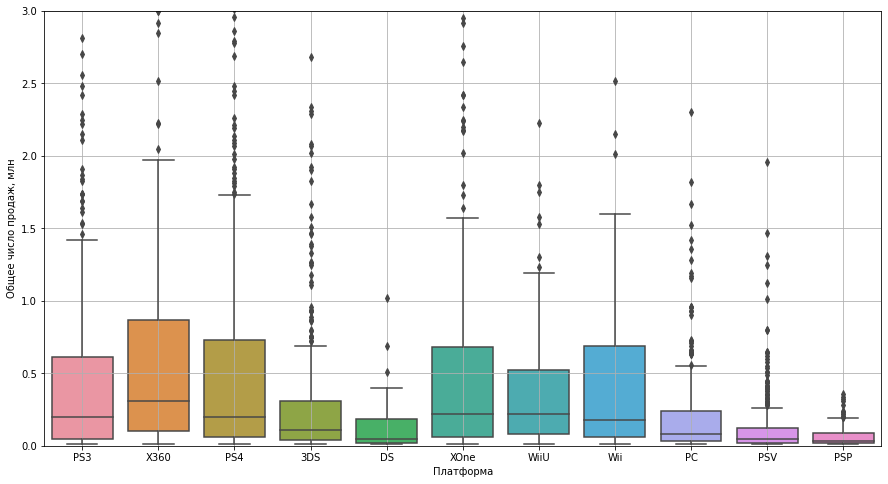

In [48]:
#ящик с усами по годам для 
plt.figure(figsize=(15,8))
sns.boxplot(x=data_actual['platform'], y=data_actual['total_sales']);
plt.xlabel('Платформа')
plt.ylabel('Общее число продаж, млн')
plt.ylim(0, 3);


**Вывод**

Чем больше продаж на платформе, тем больше разброс значений, тем дальше выбросы от медианы. Но есть и исключения, например, платформа DS, которая показывает крайне малое количество выбросов и, вообще, продажи для этой платформы распределины очень "сжато" (малое расстояние между 1 и 3 квартилями)
Все медианы по всем платформам находятся на уровне не выше 0,4.

### Влияние отзывов на продажи

In [32]:
#отбор данных для одной популярной платформы
data_for_corr_x360 = data_actual.query('platform == "X360"')
data_for_corr_ps3 = data_actual.query('platform == "PS3"')
data_for_corr_ps4 = data_actual.query('platform == "PS4"')

In [33]:
#сброс индексов
data_for_corr_x360 = data_for_corr_x360.reset_index(drop=True)
data_for_corr_ps3 = data_for_corr_ps3.reset_index(drop=True)
data_for_corr_ps4 = data_for_corr_ps4.reset_index(drop=True)

#### Анализ продаж для платформы X360

Матрица рассеяния между оценками и продажами на платформе X360


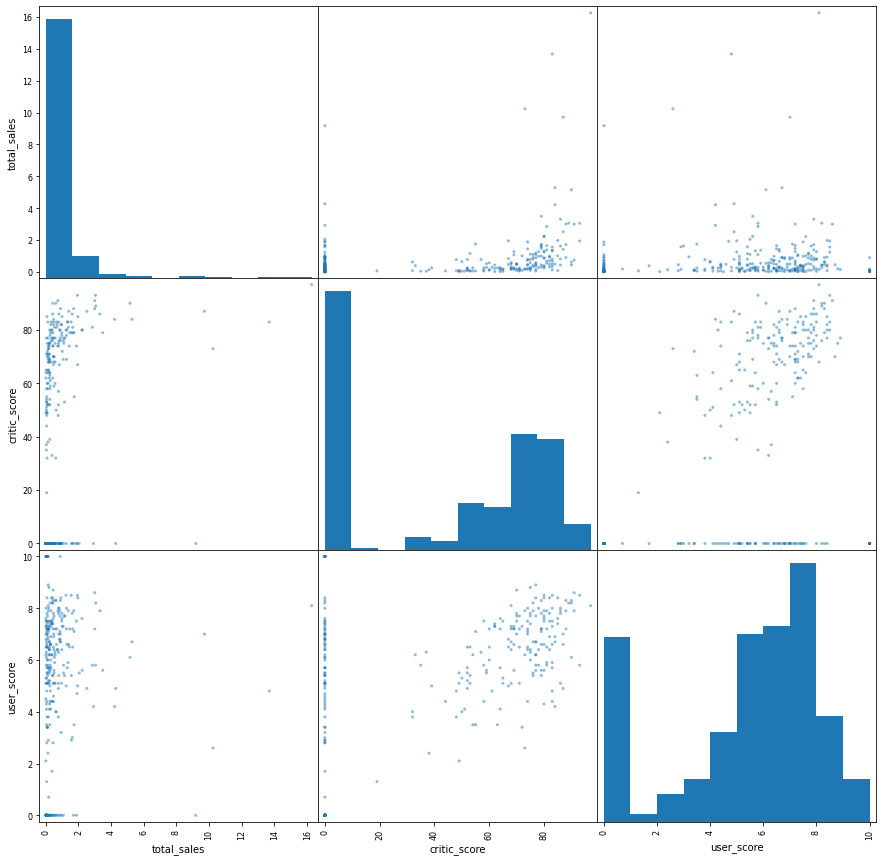

In [34]:
#построим матрицу диаграмм рассеяния
pd.plotting.scatter_matrix(data_for_corr_x360.loc[:,['total_sales', 'critic_score', 'user_score']], figsize=(15, 15));
print('Матрица рассеяния между оценками и продажами на платформе X360');

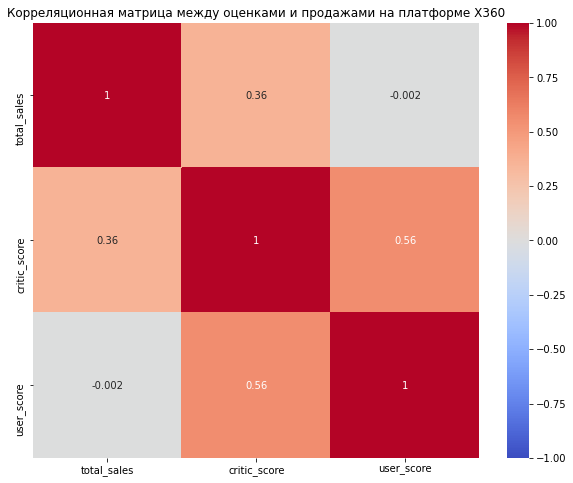

In [35]:
#построим матрицу корреляций для 'total_sales', 'critic_score', 'user_score'
plt.figure(figsize=(10, 8));
sns.heatmap(data_for_corr_x360
            .loc[:, ['total_sales', 'critic_score', 'user_score']]  #отбор нужных столбцов
            .query('critic_score!=0 and user_score!=0 and user_score!=10')  #отбор ненулевых значений
            .corr(), annot=True, cmap='coolwarm', vmin=-1 # построение матрицы корреляции
           );
plt.title('Корреляционная матрица между оценками и продажами на платформе X360');

#### Анализ продаж для платформы PS3

Матрица рассеяния между оценками и продажами на платформе PS3


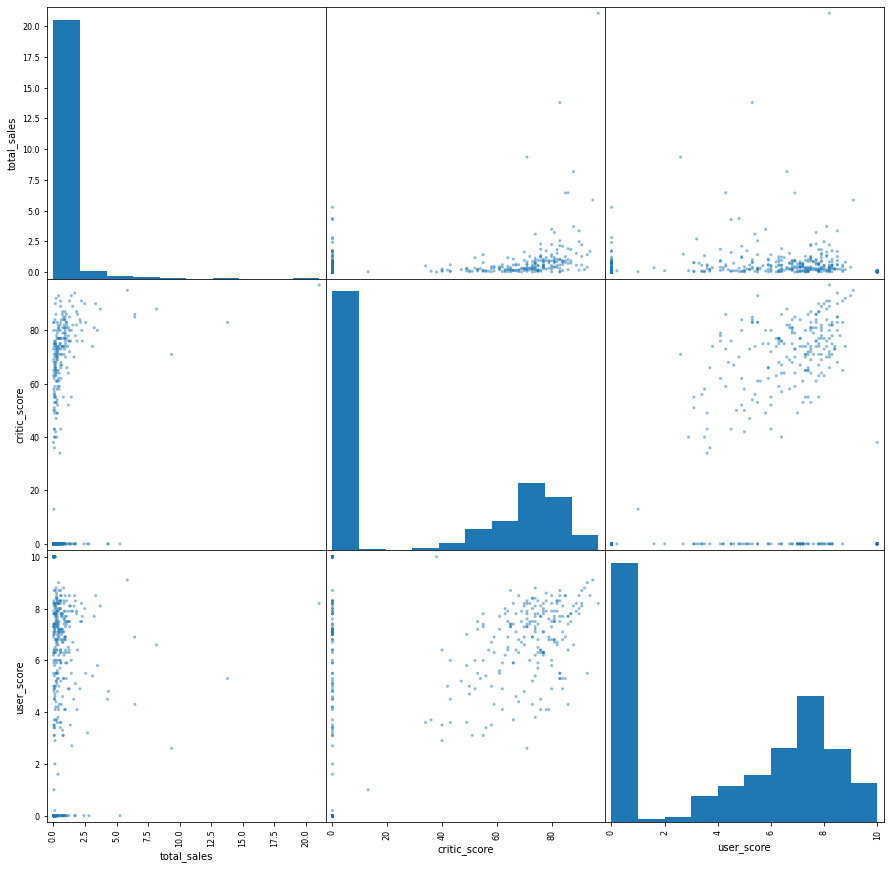

In [36]:
#построим матрицу диаграмм рассеяния
pd.plotting.scatter_matrix(data_for_corr_ps3.loc[:,['total_sales', 'critic_score', 'user_score']], figsize=(15, 15));
print('Матрица рассеяния между оценками и продажами на платформе PS3');

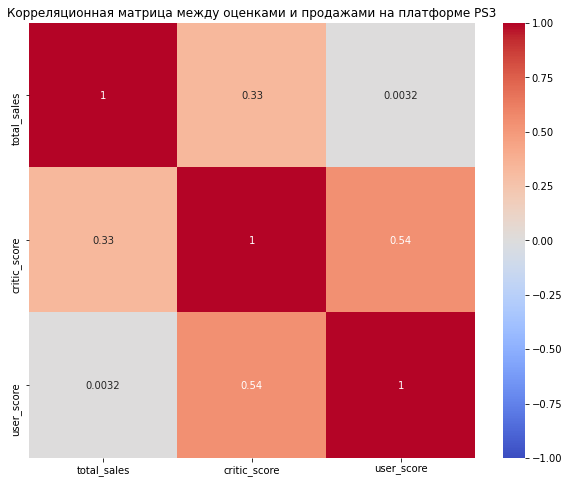

In [37]:
#построим матрицу корреляций для 'total_sales', 'critic_score', 'user_score'
plt.figure(figsize=(10, 8));
sns.heatmap(data_for_corr_ps3
            .loc[:, ['total_sales', 'critic_score', 'user_score']]  #отбор нужных столбцов
            .query('critic_score!=0 and user_score!=0 and user_score!=10')  #отбор ненулевых значений
            .corr(), annot=True, cmap='coolwarm', vmin=-1 # построение матрицы корреляции
           );
plt.title('Корреляционная матрица между оценками и продажами на платформе PS3');

#### Анализ продаж для платформы PS4

Матрица рассеяния между оценками и продажами на платформе PS4


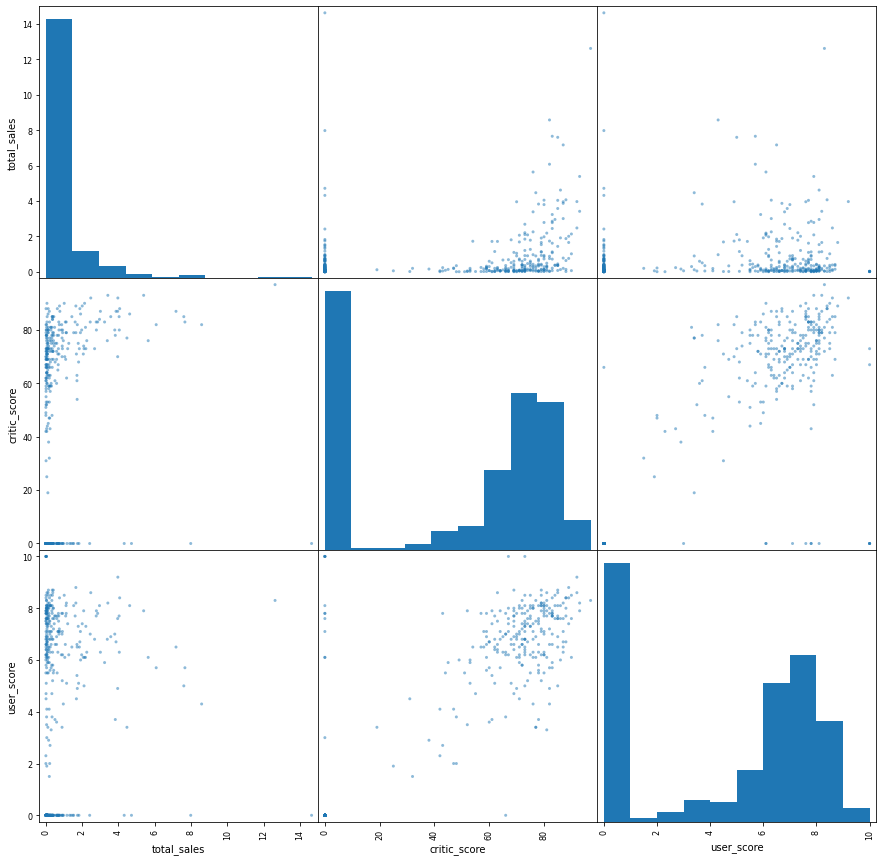

In [38]:
#построим матрицу диаграмм рассеяния
pd.plotting.scatter_matrix(data_for_corr_ps4.loc[:,['total_sales', 'critic_score', 'user_score']], figsize=(15, 15));
print('Матрица рассеяния между оценками и продажами на платформе PS4');

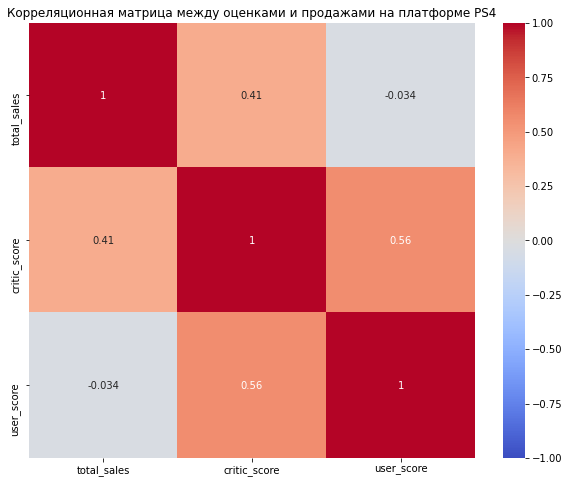

In [39]:
#построим матрицу корреляций для 'total_sales', 'critic_score', 'user_score'
plt.figure(figsize=(10, 8));
sns.heatmap(data_for_corr_ps4
            .loc[:, ['total_sales', 'critic_score', 'user_score']]  #отбор нужных столбцов
            .query('critic_score!=0 and user_score!=0 and user_score!=10')  #отбор ненулевых значений
            .corr(), annot=True, cmap='coolwarm', vmin=-1 # построение матрицы корреляции
           );

plt.title('Корреляционная матрица между оценками и продажами на платформе PS4');

**Вывод**

Корреляционный анализ проведен на топ-3 платформах:
- X360
- PS3
- PS4

Наблюдается незначительная положительная корреляции между продажами и оценками пользователей и критиков.

### Распределение игр по жанрам

In [40]:
#сводная таблица с подсчетом продаж и количества игр по жанрам
data_genre_pivot = data_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'median', 'count'])
data_genre_pivot.columns = ['total_sales', 'median_sales', 'count_of_games']  #переименование столбцов
data_genre_pivot = data_genre_pivot.sort_values('median_sales', ascending=False)  #сортировка
data_genre_pivot

,total_sales,median_sales,count_of_games
genre,,,
Shooter,304.80,0.435,236
Sports,181.09,0.240,269
Platform,61.00,0.210,85
Role-Playing,193.09,0.140,372
Racing,53.59,0.135,116
Fighting,44.49,0.130,109
Action,441.52,0.120,1032
Misc,85.04,0.120,192
Simulation,35.61,0.120,82


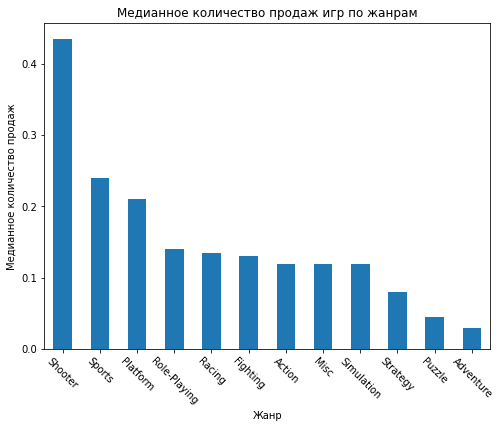

In [41]:
#график медианных значений продаж по платформам
data_genre_pivot['median_sales'].plot(kind='bar', figsize=(8, 6), title='Медианное количество продаж игр по жанрам', 
                              xlabel='Жанр', ylabel='Медианное количество продаж');
plt.xticks(rotation=-45);

**Вывод**

Жанр, который в среднем на игру приносит больше всего и лидирует с большим отрывом - это `Shooter` (0.438 - медиана)

Второе и третье места занимают жанры `Sports` и `Platform` (медиана 0.240 и 0.210 соответсвенно).

## Портрет пользователя каждого региона

### Топ-5 популярных платформ

In [42]:
#получение данных о продажах по топ5 какой-либо группы для региона
def top5_sales_continent(group, cont_sales):
    
    #рассчет продаж по группам (сводная таблица)
    data_actual_cont = data_actual.pivot_table(index=group, values=cont_sales, aggfunc='sum') 
    
    #сброс индексов и сортировка по убыванию
    data_actual_cont = data_actual_cont.sort_values(cont_sales, ascending=False).reset_index() 
    
    total_sales = 0  #суммарное количество продаж
    other_sales = 0  #суммарное количетство продаж для топ5 платформ

    for i in range (0, data_actual_cont.shape[0]):  #подсчет суммарного количество продаж
        total_sales += data_actual_cont.loc[i, cont_sales]
        
    for i in range (5, data_actual_cont.shape[0]):  #подсчет суммарного количества продаж для топ5
        other_sales += data_actual_cont.loc[i, cont_sales]
    
    #берем 5 верхних строк (топ) и добавляем к ним строку с суммарным количеством оставшихся платформ
    data_actual_cont = data_actual_cont.head().append({group : 'other', cont_sales : other_sales}, ignore_index=True)  
    
    #добавление долей продаж по региону
    data_actual_cont['part'] = (data_actual_cont[cont_sales] / total_sales * 100).round(1)  
    
    #набор цветов для диаграммы
    colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897', '#7F6272', '#D7C3F3']
    # создание диаграммы "пирог"
    return plt.pie(data_actual_cont['part'], labels=data_actual_cont[group], labeldistance=1.15, 
                   wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors, 
                   data=data_actual_cont['part'], autopct='%.1f%%')

Доли продаж на самых популярных платформах в Северной Америке


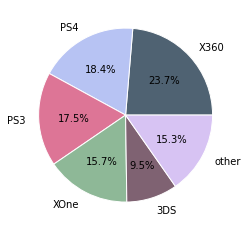

In [43]:
#рассчет топ5 платформ для сев.ам.
print('Доли продаж на самых популярных платформах в Северной Америке')
top5_sales_continent('platform', 'na_sales');

Доли продаж на самых популярных платформах в Европе


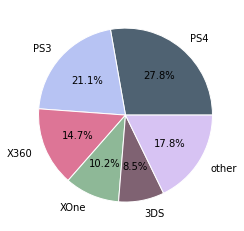

In [44]:
#рассчет топ5 платформ для европы
print('Доли продаж на самых популярных платформах в Европе')
top5_sales_continent('platform', 'eu_sales');

Доли продаж на самых популярных платформах в Японии


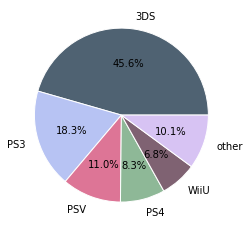

In [45]:
#рассчет топ5 платформ для японии
print('Доли продаж на самых популярных платформах в Японии')
top5_sales_continent('platform', 'jp_sales');

Доли продаж на самых популярных платформах в прочих регионах мира


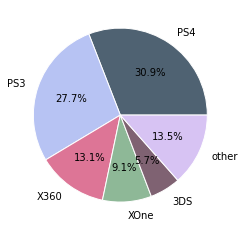

In [46]:
#рассчет топ5 платформ для остальных регионов
print('Доли продаж на самых популярных платформах в прочих регионах мира')
top5_sales_continent('platform', 'other_sales');

**Вывод**

На разных контенентах популярные платформы немного разнятся.

На фоне всех регионов особенно выделяется Япония. В ней топ-5 входят платформы: PSV PSP и WiiU, которые не входят в топы в других регионах мира.

Во всех остальных регионах примерно одинаково популярны: PS3, PS4, X360, XOne, 3DS.

### Топ-5 популярных жанров

Доли продаж игр по самым популярным жанрам в Северной Америке


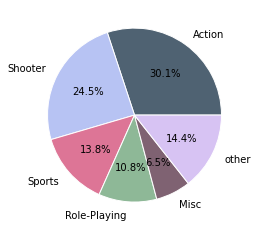

In [47]:
#рассчет топ5 жанров для сев.ам.
print('Доли продаж игр по самым популярным жанрам в Северной Америке')
top5_sales_continent('genre', 'na_sales');

Доли продаж игр по самым популярным жанрам в Европе


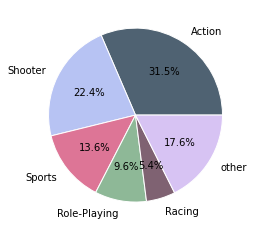

In [48]:
#рассчет топ5 жанров для европы
print('Доли продаж игр по самым популярным жанрам в Европе')
top5_sales_continent('genre', 'eu_sales');

Доли продаж игр по самым популярным жанрам в Японии


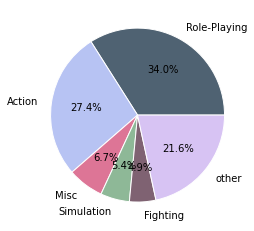

In [49]:
#рассчет топ5 жанров для японии.
print('Доли продаж игр по самым популярным жанрам в Японии')
top5_sales_continent('genre', 'jp_sales');

Доли продаж игр по самым популярным жанрам в прочих регионах мира


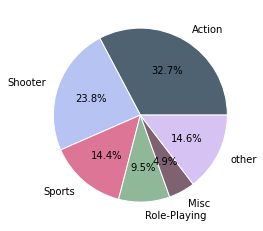

In [50]:
#рассчет топ5 жанров для остальных регионов
print('Доли продаж игр по самым популярным жанрам в прочих регионах мира')
top5_sales_continent('genre', 'other_sales');

**Вывод**

В плане жанров Япония опять же выделяется. Во всех регионах самый популярный жанр - Action. Тогда как в Японии - Role-Playing. Также в Японии присутсвуют в топе жанры: Simulation и Fighting, которые не присутсвуют в топ-5 по всему остальному миру.

Во всех остальных регионах топ-5 выглядит следующим образом:
- Acrion
- Shooter
- Sports
- Role_Playing
- Misc

### Влияние рейтинга ESRB на продажи

In [51]:
#подсчет продаж по рейтингу для региона
def rating_region(region):
    rating_sales_pivot = data_actual.pivot_table(index='rating', values=region, aggfunc='sum')
    return rating_sales_pivot.sort_values(region, ascending=False)

In [52]:
#рассчет продаж по рейтингу для сев.ам.
rating_region('na_sales')

,na_sales
rating,
M,231.57
E,114.49
unknown,103.59
E10+,75.96
T,66.31


In [53]:
#рассчет продаж по рейтингу для сев.ам.
rating_region('eu_sales')

,eu_sales
rating,
M,193.96
E,113.05
unknown,91.50
E10+,55.56
T,53.01


In [54]:
#рассчет продаж по рейтингу для сев.ам.
rating_region('jp_sales')

,jp_sales
rating,
unknown,108.89
E,28.33
T,26.09
M,21.20
E10+,8.19


In [55]:
#рассчет продаж по рейтингу для сев.ам.
rating_region('other_sales')

,other_sales
rating,
M,63.38
E,31.46
unknown,27.19
T,17.98
E10+,16.27


**Вывод**

По текущим данным трудно судить о реальном положении дел, т.к. оклоло 40% записей в датасете не имеет рейтинга.
Если оценивать те данные, которые имеются в распоряжении, то во всем мире, кроме Японии, наиболее продаваемыми являются игры с рейтингом М (для взрослых).Далее идут игры для всех, потом для тех, кто старше 10 лет, потом для тех, кто старше 13 лет.

В Японии самыми продаваемыми играми идут игры с рейтингом E (для всех), потом дети старше 13 лет, потом взрослые, потом дети старше 10 лет.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотезы:

H0 - средние пользовательские рейтинги для платформ Xbox One и PC одинаковые

H1 - средние пользовательские рейтинги для платформ Xbox One и PC не равны

In [56]:
#проверяем гипотезу H0
alpha = 0.05

result = st.ttest_ind(data_actual.query('platform == "XOne"')['user_score'], 
                      data_actual.query('platform == "PC"')['user_score'], 
                      alternative='two-sided')

print('pvalue =', result.pvalue)

if result.pvalue > alpha:
    print('Нулевую гипотезу не можем отвергнуть')
else:
    print('Нулевую гипотезу отвергаем')

pvalue = 0.3571533292689786
Нулевую гипотезу не можем отвергнуть


**Вывод**

Невозможно опровергнуть, что средние пользовательские рейтинги платформ Xbox One и PC равны.

### Средние пользовательские рейтинги жанров Action и Sports разные

Гипотезы:

H0 - средние пользовательские рейтинги жанров Action и Sports одинаковые

H1 - средние пользовательские рейтинги жанров Action и Sports не равны

In [57]:
#проверяем гипотезу H0
alpha = 0.05

result = st.ttest_ind(data_actual.query('genre == "Action"')['user_score'], 
                      data_actual.query('genre =="Sports"')['user_score'], 
                      alternative='two-sided')

print('pvalue =', result.pvalue)

if result.pvalue > alpha:
    print('Нулевую гипотезу не можем отвергнуть')
else:
    print('Нулевую гипотезу отвергаем')

pvalue = 0.0029460914760781293
Нулевую гипотезу отвергаем


**Вывод**

Пользовательские рейтинги для жанров Action и Sports не равны.

## Выводы

На текущий момент актуальным периодом, который можно использовать для прогноза продаж в следующем году: 2012 - наст.вр. В этот период продажи игр из года в год имеют стабильное значение.

В результате исследования выявлено, что после появления новой платформы, игры для нее продаются в течение примерно 11 лет. В текущий момент популярны следующие платформы у покупателей:
- PS3
- PS4 
- X360 
- 3DS 
- XOne 

Платформы PS4 и XOne находятся сейчас в первой половине своего 11-летнего цикла продаж. Поэтому продажи год от года для этих платформ растут.

Остальные платформы показывают ежегодное падение.

Медианное значение продаж по всем платформам не превышает значения 0.4 млн.

Жанр, который в среднем на игру приносит больше всего продаж - это `Shooter` (0.438 - медиана количества продаж)

Наблюдается незначительная положительная корреляции между продажами и оценками пользователей и критиков.

Если рассматривать продажи по регионам, то стоит все регионы разделить на две группы: Япония и остальные регионы.

Топ-5 популярных платформ в Японии:
- PSV
- PSP
- WiiU
- PS3
- 3DS

Топ-5 популярных платформ в остальном мире:
- PS3
- PS4
- X360
- XOne
- 3DS

Топ-5 популярных жанров в Японии:
- Role-Playing
- Simulation
- Fighting
- Acrion
- Misc

Топ-5 популярных жанров в остальном мире:
- Acrion
- Shooter
- Sports
- Role_Playing
- Misc

Анализ данных по возрастному рейтингу требует дополнительной проработки. У 40% игр в датасете отсутвует возрастной рейтинг. Необходимо искать причину этого явления. Анализ имеющихся данных проведен, но его нельзя считать окончательным.

Возрастной рейтинг в Японии (по убыванию количества продаж) (на первые две катигории приходится более 60% продаж):
- E 
- T 
- M 
- E10+ 

Возрастной рейтинг в остальном мире (по убыванию количества продаж) (на первые две катигори приходится более 50% продаж):
- М 
- E
- E10
- T